# SENTIMENTAL AI
# SnT Summer Project, BCS-IITK
## WEEK-1 Assignment-1

Reference- https://github.com/casperbh96/Neural-Network-From-Scratch 

## Neural Networks From Scratch

The idea is that we show the very explicit implementation in NumPy, where we have to do much of the work, then afterwards, we switch to the most popular Python packages for building neural networks, to show just how easier it makes our lives.

- NumPy
- TensorFlow


We will focus on the following 4-layer neural network, with fully connected layers in this notebook. Ideally, you can develop further on and improve the NumPy approach, while modifying the layers TensorFlow to use convolutions and filters.

### Prepare a Dataset

For this walkthrough, we will focus on importing the MNIST dataset and using that as the input to our deep neural networks. Note that this is purely a demonstration of how to make a neural network from scratch, and it is NOT the recommended architecture for solving the MNIST problem.

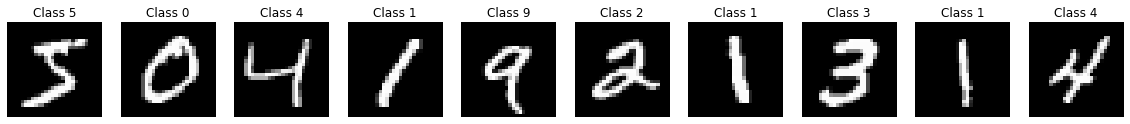

In [6]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import time

# Download the MNIST handwritten digits dataset.
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Visualize some samples.

n = 10                               # number of samples
plt.figure(figsize=(n*2, 2))
for i in range(n):
    plt.subplot(1, n, i+1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title("Class {}".format(y_train[i]))
    plt.axis('off')
plt.show()




#### Preprocess Dataset

In [7]:
def process_x(x):
    x = x/255 # Normalize the images to [0,1]
    x = np.reshape(x,(x.shape[0],784)) # Flatten the images
    
    assert x.shape[1] == 784

    return x

def process_y(y):
    y = tf.one_hot(y,10) # One-hot encode the labels (HINT: use tf.one_hot)

    assert y.shape[1] == 10
    return y

x_train = process_x(x_train)
x_test = process_x(x_test)
y_train = process_y(y_train)
y_test = process_y(y_test)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 784),
 TensorShape([60000, 10]),
 (10000, 784),
 TensorShape([10000, 10]))

### 4-layer Neural Network with NumPy

In [8]:
class DeepNeuralNetwork():
    def __init__(self, sizes, epochs=10, l_rate=0.001):
        self.sizes = sizes
        self.epochs = epochs
        self.l_rate = l_rate

        # we save all parameters in the neural network in this dictionary
        self.params = self.initialization()

    def sigmoid(self, x, derivative=False):
        # if derivative is True, return the derivative of the sigmoid function
        # else return the sigmoid function

        # your code here
        s=np.exp(-x)
        s=1/(1+s)
        if derivative==True:
            sigmoid=s*(1-s)
        else: 
            sigmoid=s
        return sigmoid    
        
        
        

    def softmax(self, x, derivative=False):
        # Numerically stable with large exponentials
        # if derivative is True, return the derivative of the softmax function
        # else return the softmax function
        
        exps = np.exp(x - x.max())
        s=np.sum(exps,axis=0)
        s=exps/s
        if derivative:
            return s*(1-s)
        else:
            return s
       

    def initialization(self):
        # number of nodes in each layer
        input_layer=self.sizes[0]
        hidden_1=self.sizes[1]
        hidden_2=self.sizes[2]
        output_layer=self.sizes[3]

        # Initialize weights
        # W1 are the weights for hidden layer 1
        # W2 are the weights for hidden layer 2
        # W3 are the weights for output layer
        # you should initialize these weights with random values between 0 and 1
        # Hint- use np.random.randn(...)
        
        params = {
            'W1': np.random.randn(hidden_1,input_layer),
            'W2': np.random.randn(hidden_2,hidden_1),
            'W3': np.random.randn(output_layer,hidden_2)
           
           
        }

        return params

    def forward_pass(self, x_train):
        '''
            Implement the forward pass of the neural network
            You should return the output of the neural network on x_train
        '''
        params = self.params

        # input layer activations becomes sample
        params['A0'] = x_train.T

        # input layer to hidden layer 1
        params['Z1'] = np.matmul(params['W1'],params['A0']) # output of the hidden layer 1 before activation (Hint: you have to just multiply 2 matrices...)
        params['A1'] = self.sigmoid(params['Z1']) # output of the hidden layer 1 after activation

        # hidden layer 1 to hidden layer 2
        params['Z2'] = np.matmul(params['W2'],params['A1']) # output of the hidden layer 2 before activation
        params['A2'] = self.sigmoid(params['Z2']) # output of the hidden layer 2 after activation

        # hidden layer 2 to output layer
        params['Z3'] = np.matmul(params['W3'],params['A2']) # output of the output layer before activation
        params['A3'] = self.sigmoid(params['Z3']) # output of the output layer after activation

        return params['A3']

    def backward_pass(self, y_train, output):
        '''
            This is the backpropagation algorithm, for calculating the updates
            of the neural network's parameters.

                  Some warnings you may encounter: 
                  RuntimeWarning: invalid value encountered in true_divide
                  RuntimeWarning: overflow encountered in exp
                  RuntimeWarning: overflow encountered in square
            This function could be tricky to implement.
            Thats why we have provided a solution.
            Feel free to implement your own solution.
            It must return the updates for the weights.
        '''
        params = self.params
        change_w = {}

        # Calculate W3 update
        error = 2 * (output - y_train) / output.shape[0] * self.softmax(params['Z3'], derivative=True)
        change_w['W3'] = np.outer(error, params['A2'])

        # Calculate W2 update
        error = np.dot(params['W3'].T, error) * self.sigmoid(params['Z2'], derivative=True)
        change_w['W2'] = np.outer(error, params['A1'])

        # Calculate W1 update
        error = np.dot(params['W2'].T, error) * self.sigmoid(params['Z1'], derivative=True)
        change_w['W1'] = np.outer(error, params['A0'])

        return change_w

    def update_network_parameters(self, changes_to_w):
        '''
            Update network parameters according to update rule from
            Stochastic Gradient Descent.

            θ = θ - η * ∇J(x, y), 
                theta θ:            a network parameter (e.g. a weight w)
                eta η:              the learning rate
                gradient ∇J(x, y):  the gradient of the objective function,
                                    i.e. the change for a specific theta θ
        '''
        params=self.params
        for key, value in changes_to_w.items():
             params[key]-=self.l_rate*value
        self.params=params        
    def compute_accuracy(self, x_val, y_val):
        '''
            This function does a forward pass of x, then checks if the indices
            of the maximum value in the output equals the indices in the label
            y. Then it sums over each prediction and calculates the accuracy.
        '''
        predictions = []

        for x, y in zip(x_val, y_val):
            output = self.forward_pass(x)
            pred = np.argmax(output) # get the label of predictions
            actual=np.argmax(y)
            if actual==pred:
                predictions.append(pred)
        
        return len(predictions)/len(x_val)

    def train(self, x_train, y_train, x_val, y_val):
        start_time = time.time()

        # Train the network
        for iteration in range(self.epochs):
            for x,y in zip(x_train, y_train):
                # compute the output of network
                output = self.forward_pass(x)



                # calculate updates to the network's parameters
                changes_to_w = self.backward_pass(y,output)

                # update the network's parameters
                self.update_network_parameters(changes_to_w)
            
            # compute the accuracy on the validation set
            accuracy = self.compute_accuracy(x_val, y_val)
            print('Epoch: {0}, Time Spent: {1:.2f}s, Accuracy: {2:.2f}%'.format(
                iteration+1, time.time() - start_time, accuracy * 100
            ))

    def predict(self, x_test):
        # return the output of the network on x_test
        # should return the label [0-9] for each sample in x_test
        predictions = []
        for x in x_test:
            output=self.forward_pass(x)
            pred=np.argmax(output)
            predictions.append(pred)
        
        return predictions

In [10]:
np.random.seed(1)
# INitialize the network
dnn = DeepNeuralNetwork(sizes=[784, 128, 64, 10])

# Start the Training!
dnn.train(x_train[1:10000], y_train[1:10000], x_test[1:2000],y_test[1:2000])

Epoch: 1, Time Spent: 788.17s, Accuracy: 11.76%
Epoch: 2, Time Spent: 841.22s, Accuracy: 11.36%
Epoch: 3, Time Spent: 887.87s, Accuracy: 9.20%
Epoch: 4, Time Spent: 934.21s, Accuracy: 9.80%
Epoch: 5, Time Spent: 980.33s, Accuracy: 9.95%
Epoch: 6, Time Spent: 1025.68s, Accuracy: 10.41%
Epoch: 7, Time Spent: 1071.80s, Accuracy: 10.86%
Epoch: 8, Time Spent: 1121.19s, Accuracy: 11.36%
Epoch: 9, Time Spent: 1167.64s, Accuracy: 11.86%
Epoch: 10, Time Spent: 1215.74s, Accuracy: 12.31%


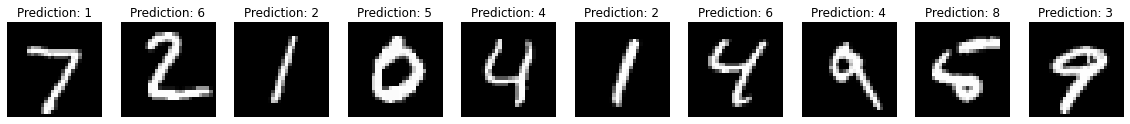

In [11]:
# Visualize the results

y_pred_np = dnn.predict(x_test)

n = 10
plt.figure(figsize=(n*2,4))
for i in range(n):
    plt.subplot(1,n,i+1)
    plt.imshow(x_test[i].reshape(28,28), cmap='gray')
    plt.axis('off')
    plt.title('Prediction: {0}'.format(y_pred_np[i]))

## **TensorFlow** 2.0 with Keras

In [16]:
# the layers class is used to define differetn layers in the model
from tensorflow.keras import layers

In [19]:
# Build the model using tf.keras.Sequential class
# You can use other methods to define your model as well
input_shape=(28,28)
model = tf.keras.Sequential([tf.keras.layers.Flatten(input_shape=input_shape),
                              tf.keras.layers.Dense(128, activation='relu'),
                              tf.keras.layers.Dense(64, activation='relu'),
                              tf.keras.layers.Dense(32, activation='relu'),
                              tf.keras.layers.Dense(10, activation='softmax'),                             
])

# Compiling the moodel involves choosing an optimizer and a loss function and the metric you want to use.
model.compile(optimizer= 'adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])




In [20]:
# Thats it! You can now start the training.
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10


2022-06-10 22:37:37.194096: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1865/1875 [============================>.] - ETA: 0s - loss: 0.8804 - accuracy: 0.8351

2022-06-10 22:37:45.807077: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 10s 5ms/step - loss: 0.8768 - accuracy: 0.8356 - val_loss: 0.3464 - val_accuracy: 0.9166
Epoch 2/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2589 - accuracy: 0.9324 - val_loss: 0.2287 - val_accuracy: 0.9387
Epoch 3/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1784 - accuracy: 0.9522 - val_loss: 0.1687 - val_accuracy: 0.9544
Epoch 4/10
1875/1875 [==============================] - 8s 5ms/step - loss: 0.1387 - accuracy: 0.9611 - val_loss: 0.1522 - val_accuracy: 0.9589
Epoch 5/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1178 - accuracy: 0.9679 - val_loss: 0.1533 - val_accuracy: 0.9561
Epoch 6/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1020 - accuracy: 0.9718 - val_loss: 0.1445 - val_accuracy: 0.9658
Epoch 7/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0898 - accuracy: 0.9746 - val_loss: 0.1291 - val_accuracy: 0.9685
Ep

2022-06-10 22:39:12.869188: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


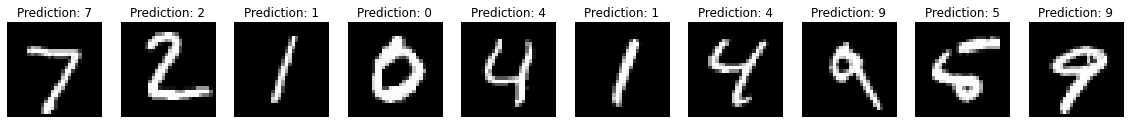

In [21]:
# Visualize the results

y_pred_tf = np.argmax(model.predict(x_test),axis=1)

n = 10
plt.figure(figsize=(n*2,4))
for i in range(n):
    plt.subplot(1,n,i+1)
    plt.imshow(x_test[i].reshape(28,28), cmap='gray')
    plt.axis('off')
    plt.title('Prediction: {0}'.format(y_pred_tf[i]))

Write the answers for the following questions in the markdown cell (double click cell to edit) below-

### Questions:

Q: Why the accuracy of the keras model is higher than our numpy model? (Hint: there is a important factor not implemented in numpy model..) 

A: Keras uses pre trained weights unlike numpy, which uses random initial weights.


Q: List down all factors due to which numpy model is slow. 

A: Keras calculates the differentials automatically while numpy does not, it has to do it seperately


Q: Is the model overfitting? underfitting? explain. 

A: The keras model is overfitting because the accuracy is so high, while the numpy model is underfitting because the accuracy is low.